# RAG System Using Langchain

In [ ]:
%%capture

!pip install -q transformers
!pip install -p bitsandbytes==0.41.3 accelerate==0.26.0

!pip -q install langchain
!pip install einops

!pip install --upgrade --quiet  langchain-community qdrant-client

!pip install langchainhub

!pip install -U langchain-huggingface

!pip install --upgrade --quiet  arxiv
!pip install --upgrade --quiet  pymupdf

In [ ]:
%%capture
!pip install -U bitsandbytes

In [ ]:
import torch
import os
import json
import numpy as np
import time


from pprint import pprint

import locale

from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaTokenizerFast
from transformers import pipeline, BitsAndBytesConfig

from langchain_huggingface import HuggingFacePipeline


from langchain import PromptTemplate, LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Qdrant
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.utils.math import cosine_similarity

from langchain_community.document_loaders import TextLoader

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import userdata
token = userdata.get('huggingface')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from PIL import Image
image1 = Image.open('/content/drive/MyDrive/capstone_project/image_data/aluminum_can/Image_136.png')

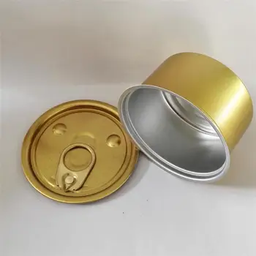

In [ ]:
image1

## Model Config

In [ ]:
%%capture

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
%%capture

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=quantization_config
)

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


## Loading the guide(s) and chunking the text

In [ ]:
# import reycling guide(s)
with open('/content/drive/MyDrive/capstone_project/cook_county_recycling_instruc_new.txt', 'r') as file:
    cc_guide = file.read()

In [ ]:
with open('/content/drive/MyDrive/capstone_project/palm_desert.txt', 'r') as file:
    pd_guide = file.read()

In [ ]:
# annie's recycling guides
recycling_instruction_dic = {"Cook County, IL":["Metal objects that are able to be recycled includes steel and aluminum containers and foil.",
                    "paper that can be recycled includes cardboard (flattened), office paper, newspaper, and magazines",
                    "glass items that can be recycled includes glass bottles and jars only",
                    """Plastic items that can be recycled includes plastic bottles, tubs, jugs, and jars only.
        Always replace your cap onto the empty and clean plastic bottle it came from.
        Then, place into your recycling bin to ensure both plastic components are successfully processed at your local recycling facility.""",
                    """A paper cup cannot be recycled and should be disposed of in the trash. Plastic lids, plastic straws, and paper cups should be kept out of your curbside recycling bin.
          Despite the paper composition of paper cups, they contain a lining that degrades the overall quality of the recycling batch and should be disposed of in the trash.""",
                    "If an item is not included in this list, please dispose of it in the garbage."],
    "Palm Desert, CA":["""The following metal and glass items can be recycled:
        -Aluminum, steel, and tin cans,
        -Clean aluminum foil,
      - Glass bottles and jars (remove lids)""", """The following paper items can be recycled:
      - White and colored paper,
      - Phone books,
      - Magazines,
      - Junk Mail,
      - Envelopes,
      - File folders,
      - Cardboard (flattened),
      - Cartons (milk, juice, & broth),
      - Books (remove hard covers or binding),
      - Cardboard boxes, e.g. cereal, etc.
        """, """Plastic items that can be recycled includes:
        - Styrofoam packing blocks
        - Plastic medicine bottles (empty)
        - Plastic bottles numbered 1-7 (remove plastic film or wrap)""",
                      "If an item is not included in this list, please dispose of it in the garbage."]}

In [ ]:
location = "Cook County, IL"
input_list = recycling_instruction_dic[location] #pd_guide #cc_guide
input_guide = "".join(input_list)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=10,
                                               length_function=len,)
#text = text_splitter.create_documents([input_guide])
splits = text_splitter.split_text(input_guide)
print('Number of splits/chunks: ', str(len(splits)))

Number of splits/chunks:  26


## Embeddings

In [ ]:
%%capture
base_embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2") # Change to align with group !!!!!!!!!!!!!!!!

## Storing the Embeddings of Chunks in Vectorstores

In [ ]:
vectorstore = Qdrant.from_texts(splits,
    base_embeddings,      #the embeddings model we just instantiated
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="test",
)
retriever = vectorstore.as_retriever() # default is similarity score

## Model Runs

In [ ]:
item = 'aluminum can'
query = f'{item}?'
docs = vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query), k=10) # will rank the splits

In [ ]:
context = ''
for i in docs:
  context = context+' '+ i.page_content

print(context)

 recycled includes steel and aluminum containers Metal objects that are able to be recycled of in the trash. Plastic lids, plastic straws, and jars onlyPlastic items that can be recycled the empty and clean plastic bottle it came from. recycled includes plastic bottles, tubs, jugs, local recycling facility.A paper cup cannot be that can be recycled includes glass bottles and of the recycling batch and should be disposed of and foil.paper that can be recycled includes


In [ ]:
# start with recycling instruction generation and work backwards

prompt = f"USER: <image>\n Given this list of recycleable items: {context}. Is {item} in the image recyclable. Please give instructions on how to recycle item in image.\nASSISTANT:"
inputs = processor(image1, prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=100, do_sample=False)
output_str = processor.decode(output[0][2:], skip_special_tokens=True)
output_idx = output_str.index("ASSISTANT") + 11

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


In [ ]:
output_str[output_idx:]

'Yes, the aluminum can in the image is recyclable. To recycle it, follow these steps:\n\n1. Remove the label and any plastic lining inside the can.\n2. Rinse the can thoroughly to remove any residue or leftover food particles.\n3. Place the can in a recycling bin or take it to a local recycling facility.\n4. If the facility accepts aluminum cans,'

In [ ]:
item = 'paper cup'
query = f'{item}?'
docs = vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query), k=3)

In [ ]:
context = ''
for i in docs:
  context = context+' '+ i.page_content

print(context)

 local recycling facility.A paper cup cannot be that can be recycled includes glass bottles and cannot be recycled and should be disposed of in


In [ ]:
image2 = Image.open('/content/drive/MyDrive/capstone_project/image_data/paper_cup/Image_146.png')

In [ ]:
#prompt = f"USER: <image>\n Given this list of recycleable items: {context}. Is {item} in the image recyclable? Please give instructions on how to recycle item in image if it is.\nASSISTANT:"
bin_class = 'no'
prompt = f"USER: <image>\n Given these instructions: {context}. Is this item able to be reyclced: {bin_class}. Please give disposal instructions for the item. \nASSISTANT:"

inputs = processor(image2, prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=100, do_sample=False)
output_str = processor.decode(output[0][2:], skip_special_tokens=True)
output_idx = output_str.index("ASSISTANT") + 11

In [ ]:
# MAKE SURE LOOP BREAKS IF THE ITEM IS NOT RECYCLEABLE for demo !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
output_str[output_idx:]

'The paper cup cannot be recycled, as it is made of paper and cannot be processed in a recycling facility. It should be disposed of in a local waste management facility or recycling bin. The instructions for disposal would be to place the paper cup in a designated waste bin or recycling area, ensuring that it is disposed of properly and does not contribute to environmental pollution.'

In [ ]:
def get_instructions(guide_path, embedding_model="all-mpnet-base-v2", image, item):
  # get location specific instructions as chunks
  with open(guide_path, 'r') as file:
    input_guide = file.read()
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=10,
                                                length_function=len,)
  splits = text_splitter.split_text(input_guide)

  # embeddings
  base_embeddings = HuggingFaceEmbeddings(model_name=embedding_model)

  # vector store with splits
  vectorstore = Qdrant.from_texts(
      splits,
      base_embeddings,      #the embeddings model we just instantiated
      location=":memory:",  # Local mode with in-memory storage only
      collection_name="test",
  )
  retriever = vectorstore.as_retriever() # default is similarity score

  # getting best vectors by similarity score
  query = f'How do I recycle {item}?'
  docs = vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query), k=10) # will rank the splits
  # formatting context
  context = ''
  for i in docs:
    context = context+' '+ i.page_content

  prompt = f"USER: <image>\n Given this list of recycleable items: {context}. Is {item} in the image recyclable. Please give instructions on how to recycle item in image.\nASSISTANT:"
  inputs = processor(image, prompt, return_tensors='pt').to(0, torch.float16)
  output = model.generate(**inputs, max_new_tokens=100, do_sample=False)
  output_str = processor.decode(output[0][2:], skip_special_tokens=True)
  output_idx = output_str.index("ASSISTANT") + 11
  out = output_str[output_idx:]
  return out

SyntaxError: non-default argument follows default argument (<ipython-input-32-8b2341b3844a>, line 1)